In [ ]:
import pandas as pd

# Load the dataset
file_path = "corporate_stress_dataset.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                50000 non-null  int64  
 1   Age                               50000 non-null  int64  
 2   Gender                            50000 non-null  object 
 3   Marital_Status                    50000 non-null  object 
 4   Job_Role                          50000 non-null  object 
 5   Experience_Years                  50000 non-null  int64  
 6   Monthly_Salary_INR                50000 non-null  float64
 7   Working_Hours_per_Week            50000 non-null  int64  
 8   Commute_Time_Hours                50000 non-null  float64
 9   Remote_Work                       50000 non-null  bool   
 10  Stress_Level                      50000 non-null  int64  
 11  Health_Issues                     37459 non-null  object 
 12  Comp

(None,
    ID  Age      Gender Marital_Status   Job_Role  Experience_Years  \
 0   1   56  Non-Binary        Widowed  Developer                 5   
 1   2   46      Female         Single    Analyst                20   
 2   3   32      Female         Single  Developer                10   
 3   4   60      Female       Divorced    Analyst                26   
 4   5   25        Male        Married      Sales                29   
 
    Monthly_Salary_INR  Working_Hours_per_Week  Commute_Time_Hours  \
 0           102703.08                      44                1.72   
 1           165583.91                      54                0.62   
 2            38005.39                      81                1.22   
 3            51127.36                      79                2.03   
 4           174597.45                      63                1.45   
 
    Remote_Work  ...  Work_Life_Balance Family_Support_Level Job_Satisfaction  \
 0         True  ...                  9                    2  

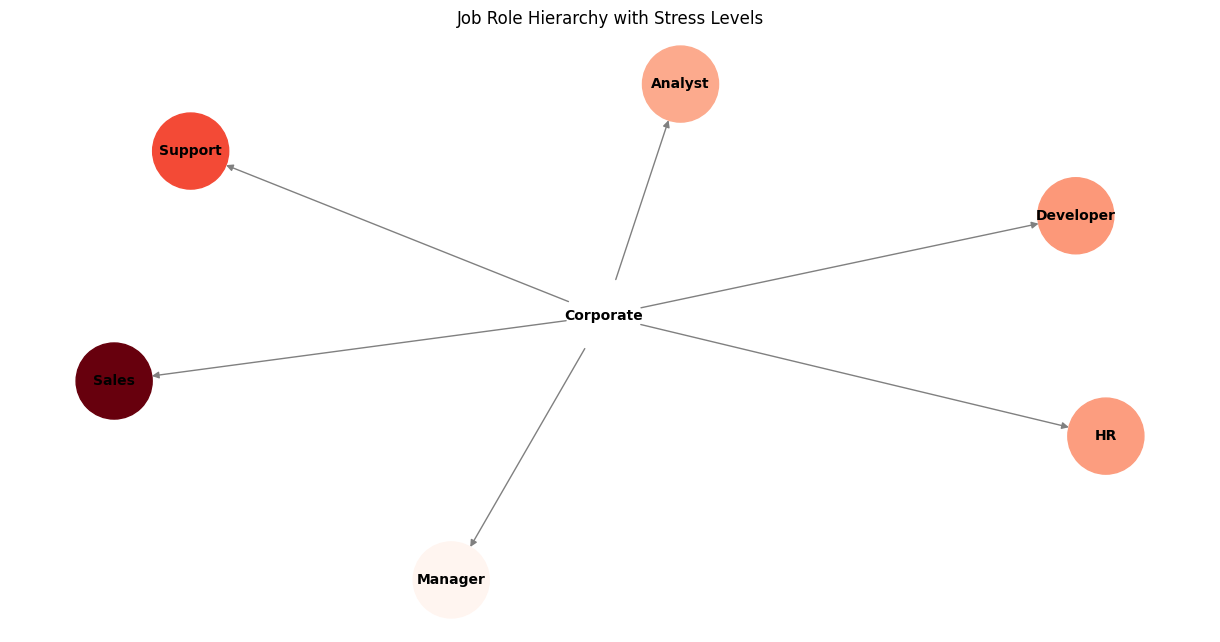

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
file_path = "corporate_stress_dataset.csv"
df = pd.read_csv(file_path)

# Sample the data for visualization (to keep it manageable)
sample_df = df.sample(n=500, random_state=42)  # Sample 500 employees

# Create a hierarchical tree structure: Job Role -> Stress Level
tree_graph = nx.DiGraph()

# Add nodes for job roles
job_roles = sample_df["Job_Role"].unique()
for role in job_roles:
    avg_stress = sample_df[sample_df["Job_Role"] == role]["Stress_Level"].mean()
    tree_graph.add_node(role, stress=avg_stress)

# Add edges from "Corporate" root node to job roles
tree_graph.add_node("Corporate", stress=None)  # Root node
for role in job_roles:
    tree_graph.add_edge("Corporate", role)

# Draw the tree
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(tree_graph, seed=42)  # Layout for visualization

# Get stress levels for coloring
stress_values = [tree_graph.nodes[n].get("stress", 0) for n in tree_graph.nodes]

# Draw nodes with color mapping based on stress level
nx.draw(tree_graph, pos, with_labels=True, node_size=3000, node_color=stress_values,
        cmap=plt.cm.Reds, edge_color="gray", font_size=10, font_weight="bold")

plt.title("Job Role Hierarchy with Stress Levels")
plt.show()


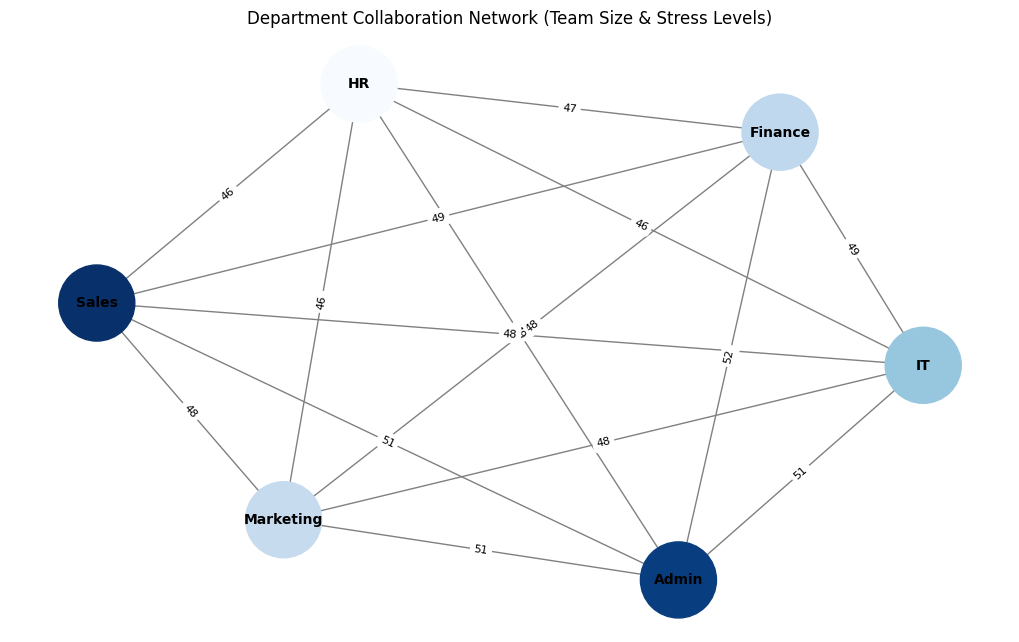

In [ ]:
# Create a network graph for department collaboration
network_graph = nx.Graph()

# Add department nodes with average stress level as a property
departments = sample_df["Department"].unique()
for dept in departments:
    avg_stress = sample_df[sample_df["Department"] == dept]["Stress_Level"].mean()
    network_graph.add_node(dept, stress=avg_stress)

# Create edges based on team size interaction (departments with overlapping teams)
for i, dept1 in enumerate(departments):
    for j, dept2 in enumerate(departments):
        if i < j:  # Avoid duplicate edges
            # Compute a similarity score based on shared employees
            team_overlap = (sample_df["Department"] == dept1).sum() + (sample_df["Department"] == dept2).sum()
            if team_overlap > 50:  # Threshold to ensure meaningful connections
                avg_team_size = (sample_df[sample_df["Department"] == dept1]["Team_Size"].mean() +
                                 sample_df[sample_df["Department"] == dept2]["Team_Size"].mean()) / 2
                network_graph.add_edge(dept1, dept2, weight=avg_team_size)

# Draw the network
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(network_graph, seed=42)  # Generate positions

# Get stress levels for node coloring
stress_values = [network_graph.nodes[n].get("stress", 0) for n in network_graph.nodes]

# Draw network with stress-based coloring
nx.draw(network_graph, pos, with_labels=True, node_size=3000, node_color=stress_values,
        cmap=plt.cm.Blues, edge_color="gray", font_size=10, font_weight="bold")

# Draw edge weights (team size)
edge_labels = {(u, v): f"{d['weight']:.0f}" for u, v, d in network_graph.edges(data=True)}
nx.draw_networkx_edge_labels(network_graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Department Collaboration Network (Team Size & Stress Levels)")
plt.show()


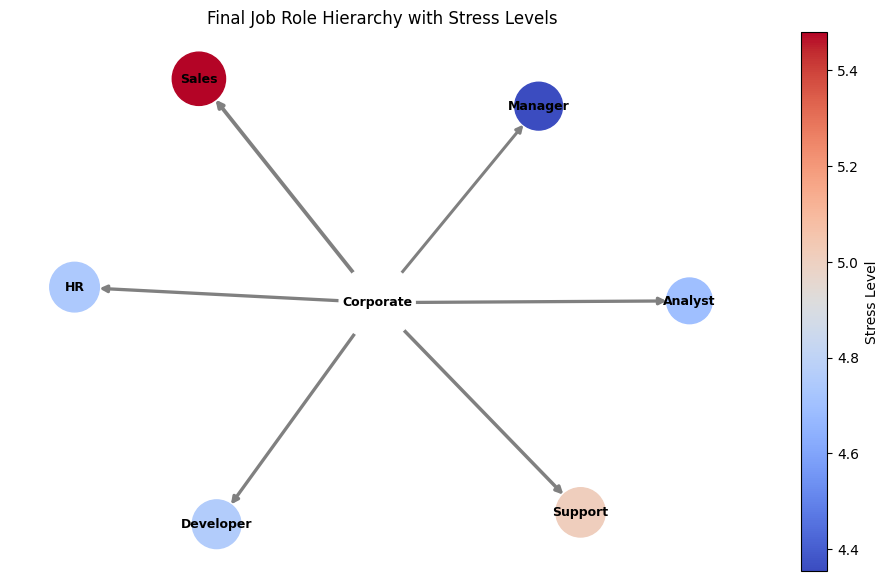

In [ ]:
# making some changes to make the graph more intuitive
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
file_path = "corporate_stress_dataset.csv"
df = pd.read_csv(file_path)

# Sample the dataset for visualization (to keep it manageable)
sample_df = df.sample(n=500, random_state=42)  # Sample 500 employees

# Create a hierarchical tree structure: Corporate -> Job Role
tree_graph = nx.DiGraph()

# Group by Job Role to get average stress levels and employee count
job_role_stats = sample_df.groupby("Job_Role").agg(
    avg_stress=("Stress_Level", "mean"),
    employee_count=("Job_Role", "count")
).reset_index()

# Add root node "Corporate"
tree_graph.add_node("Corporate", stress=None)

# Add job role nodes with stress levels and employee count
for _, row in job_role_stats.iterrows():
    tree_graph.add_node(row["Job_Role"], stress=row["avg_stress"], size=row["employee_count"])
    tree_graph.add_edge("Corporate", row["Job_Role"], weight=row["avg_stress"])

# Use spring_layout as an alternative to graphviz_layout
pos = nx.spring_layout(tree_graph, seed=42)  # Ensures hierarchy without requiring pygraphviz

# Extract stress values for normalization
stress_values = job_role_stats["avg_stress"].tolist()
min_stress, max_stress = min(stress_values), max(stress_values)

# Assign node colors (Corporate is white, others follow stress scale)
node_colors = [
    "white" if tree_graph.nodes[n].get("stress") is None else plt.cm.coolwarm(
        (tree_graph.nodes[n]["stress"] - min_stress) / (max_stress - min_stress)
    ) for n in tree_graph.nodes
]

# Extract node sizes based on employee count (scaling factor applied)
node_sizes = [
    3000 if tree_graph.nodes[n].get("stress") is None else tree_graph.nodes[n]["size"] * 15
    for n in tree_graph.nodes
]

# Extract edge widths based on stress levels (scaling factor applied)
edge_widths = [tree_graph[u][v]["weight"] / 2 for u, v in tree_graph.edges]

# Draw the tree graph
plt.figure(figsize=(12, 7))
ax = plt.gca()  # Get current Axes

# Draw the network with proper color mapping
nx.draw(
    tree_graph,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    width=edge_widths,
    font_size=9,
    font_weight="bold"
)


sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min_stress, vmax=max_stress))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Stress Level")

# Add title
plt.title("Final Job Role Hierarchy with Stress Levels")

# Show the plot
plt.show()
